In [3]:
import os
import gc
from imageio.v2 import imread
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
def get_bboxes(img):
    up=0
    down=0
    left=0
    right=0
    for ind, i in enumerate(img):
        if(255 in i):
            up=ind
            break

    for ind, i in enumerate(img.T):
        if(255 in i):
            left=ind
            break

    for ind, i in enumerate(torch.flip(img, (0,1))):
        if(255 in i):
            down=ind
            break


    for ind, i in enumerate(torch.flip(img.T, (0,1))):
        if(255 in i):
            right=ind
            break
    return [up, img.shape[0]-down, left, img.shape[1]-right]

def get_bboxes_batched(t):
    bboxes = []
    for x in t:
        bboxes.append(get_bboxes(x))
    return bboxes

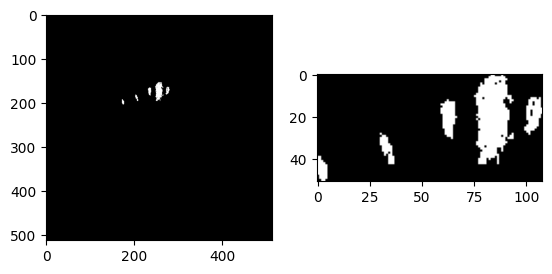

In [5]:
img = torch.tensor(imread("./2021-training-data-ZA/0DME_as_F/masks/0MASK_DME_as_F.PNG"))
plt.subplot(1,2,1)
plt.imshow(img, "gray")
up, down, left, right = get_bboxes(img)
plt.subplot(1,2,2)
plt.imshow(img[up:down, left:right], "gray")

In [6]:
def create_bbox_predictor(lr):
    model = nn.Sequential(
        nn.Conv2d(1, 4, 5, 1, 1),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(4, 4, 7, 1, 1),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(4, 4, 7, 1, 1),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(4, 4, 7, 1, 1),
        nn.AdaptiveAvgPool2d(6),
        nn.Flatten(),
        nn.Linear(144, 12),
        nn.Linear(12, 4)
    )
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    lossfunc = torch.nn.MSELoss()
    return model, optimizer, lossfunc

In [13]:
model, _, lossfunc = create_bbox_predictor(0.001)
for xy in train_loader:
    print(lossfunc(model(xy[0]), torch.tensor(get_bboxes_batched(xy[1])).float()))

tensor(57885.4297, grad_fn=<MseLossBackward0>)
tensor(73452.7344, grad_fn=<MseLossBackward0>)
tensor(58966.7422, grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

In [8]:
files = []
for folder in os.listdir("./2021-training-data-ZA"):
    image_name = os.listdir("./2021-training-data-ZA/"+folder+"/images")[0]
    mask_name = os.listdir("./2021-training-data-ZA/"+folder+"/masks")[0]
    files.append(("./2021-training-data-ZA/"+folder+"/images/"+image_name, "./2021-training-data-ZA/"+folder+"/masks/"+mask_name))

In [9]:
train_files, test_files = train_test_split(files, test_size=0.1)
len(train_files), len(test_files)

(1314, 146)

In [10]:
class ImagesDataset(Dataset):
    def __init__(self, files):
        self.files = files
    def __len__(self):
        return len(self.files)
    def __getitem__(self, index):
        image = torch.tensor(imread(self.files[index][0])).float()
        try:
            image = torch.mean(image, axis=2)
        except:
            pass
        shape = image.shape
        image = image.view( 1, shape[0], shape[1])
        image = F.pad(image,(0, 1536 - shape[1], 0, 512 - shape[0]), "constant", 0)
        mask = torch.tensor(imread(files[index][1])).float()
        shape = mask.shape
        mask = F.pad(mask,(0, 1536 - shape[1], 0, 512 - shape[0]), "constant", 0)
        return (image, mask)

In [11]:
imgds = ImagesDataset(train_files)
test_ds = ImagesDataset(test_files)

train_loader = DataLoader(imgds, 32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, len(test_ds), shuffle=True)

len(imgds), len(test_ds)

(1314, 146)

In [86]:
for xy in imgds:
    print(xy[0].shape, xy[1].shape)

torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]) torch.Size([512, 1536])
torch.Size([1, 1, 512, 1536]

RuntimeError: shape '[1, 1, 512, 512]' is invalid for input of size 786432

In [87]:
for xy in train_loader:
    print(xy[1])

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

KeyboardInterrupt: 

In [14]:
def train_model(model, optimizer, lossfunc):
    num_epochs = 10
    train_losses = torch.zeros(num_epochs)
    test_losses = torch.zeros(num_epochs)
    for i in range(num_epochs):
        print(i)
        batch_losses=[]
        j=0
        for xy in train_loader:
            yHat = model(xy[0])
            loss = lossfunc(yHat, torch.tensor(get_bboxes_batched(xy[1])).float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            del xy
        train_losses[i] = sum(batch_losses)/len(batch_losses)
        print(train_losses)
        with torch.no_grad():
            batch_losses=[]
            for test_xy in test_loader:
                yHat = model(test_xy[0])
                loss = lossfunc(yHat.int().float(), torch.tensor(get_bboxes_batched(test_xy[1])))
                batch_losses.append(loss)
                del test_xy
            test_losses[i] = sum(batch_losses)/len(batch_losses)
        print(test_losses)
        gc.collect()
    torch.save(model.state_dict(), "./models/"+"lossof"+f"{test_losses}.pt")
    return model, train_losses, test_losses

In [15]:
model, optimizer, lossfunc = create_bbox_predictor(0.001)
model, train_losses, test_losses = train_model(model, optimizer, lossfunc)
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

0
tensor([22348.3496,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000])
tensor([6565.3940,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000])
1
tensor([22348.3496,  8202.6318,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000])
tensor([6565.3940, 5843.3491,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000])
2
tensor([22348.3496,  8202.6318,  7957.7866,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000])
tensor([6565.3940, 5843.3491, 6189.8218,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000])
3
tensor([22348.3496,  8202.6318,  7957.7866,  7836.1919,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000])
tensor([6565.3940, 5843.3491, 6189.8218, 5407.1182,    0.0000, 

torch.Size([512, 512])
tensor([155, 244, 293, 377], dtype=torch.int32) [337, 364, 213, 236]


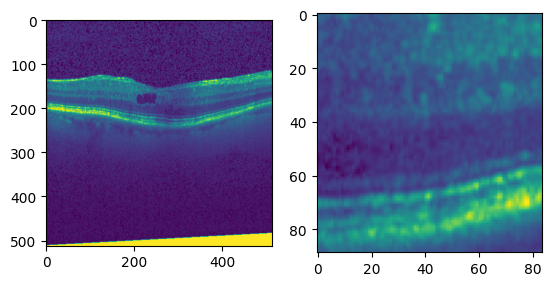

In [21]:
def plot_bounding(test_xy):
    plt.subplot(1,2,1)
    plt.imshow(test_xy[0].squeeze())
    print(test_xy[0].squeeze().shape)
    with torch.no_grad():
        bboxes = model(test_xy[0]).int().squeeze()
    print(bboxes, get_bboxes(test_xy[1].squeeze()))
    plt.subplot(1,2,2)
    plt.imshow(test_xy[0].squeeze()[bboxes[0]:bboxes[1], bboxes[2]:bboxes[3]])
plot_bounding(test_ds[123])

In [ ]:
model, train_losses, test_losses = train_model(model, optimizer, lossfunc)
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()